In [1]:
# Install required libraries (uncomment these lines if running in Colab)
!pip install numpy pandas scikit-learn tensorflow imbalanced-learn shap lime

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import shap
from lime.lime_tabular import LimeTabularExplainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e59de115602aef1b298028233788f60f0734489c56a6c7392c9bbf526f2d2a58
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
# Load and preprocess the Cleveland dataset
def load_and_preprocess(csv_path):
    # Define column names
    cols = ["age","sex","cp","trestbps","chol","fbs","restecg",
            "thalach","exang","oldpeak","slope","ca","thal","target"]
    data = pd.read_csv(csv_path, names=cols, skiprows=1)

    # Separate features and target
    X = data.drop("target", axis=1)
    y = data["target"]

    # Identify categorical vs numeric columns
    categorical_cols = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
    numeric_cols = [c for c in X.columns if c not in categorical_cols]

    # Convert categorical columns to integers (they are already numeric codes here)
    X[categorical_cols] = X[categorical_cols].astype(int)

    # Scale numeric features
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Oversample the training set to balance classes using SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # Record cardinality for each categorical (for embedding layers)
    cate_cardinalities = {col: int(X[col].nunique()) for col in categorical_cols}

    return (X_train_res, X_test, y_train_res, y_test, categorical_cols, numeric_cols, cate_cardinalities)

# Example usage:
csv_path = "Heart_disease_cleveland_new.csv"  # Adjust path as needed
X_train, X_test, y_train, y_test, cat_cols, num_cols, cate_card = load_and_preprocess(csv_path)
print("Train shape (after SMOTE):", X_train.shape, "Positive rate:", np.mean(y_train))
print("Test shape:", X_test.shape)


Train shape (after SMOTE): (262, 13) Positive rate: 0.5
Test shape: (61, 13)


In [4]:
# Build a CNN model for tabular data with embedding layers
def build_cnn_model(cat_cols, num_cols, cate_card, learning_rate, dropout_rate, n_filters):
    inputs = []
    embed_outputs = []

    # Create embedding branches for each categorical feature
    for col in cat_cols:
        # Input for one categorical feature
        inp = Input(shape=(1,), name=f"input_{col}")
        vocab_size = cate_card[col]
        # Use embedding size = min(50, (vocab+1)//2)
        embed_dim = min(50, (vocab_size + 1)//2)
        emb = Embedding(input_dim=vocab_size+1, output_dim=embed_dim, name=f"emb_{col}")(inp)
        flat = Flatten()(emb)
        inputs.append(inp)
        embed_outputs.append(flat)

    # Input for numeric features as one block
    inp_num = Input(shape=(len(num_cols),), name="input_numeric")
    inputs.append(inp_num)
    # We do not embed numeric features; pass them through directly
    embed_outputs.append(inp_num)

    # Concatenate all feature embeddings + numeric inputs
    x = Concatenate()(embed_outputs)
    # Optionally, add one Dense to mix them
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Reshape to (timesteps, features=1) for Conv1D
    # We treat concatenated features as a 1D “sequence” for convolution
    x = tf.keras.ops.expand_dims(x, axis=-1)  # shape: (batch, features, 1)

    # Convolutional block
    x = Conv1D(filters=n_filters, kernel_size=3, activation='relu', padding='same')(x)
    x = GlobalMaxPooling1D()(x)

    # Final dense layers
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example: test model building
model = build_cnn_model(cat_cols, num_cols, cate_card, learning_rate=1e-3, dropout_rate=0.2, n_filters=16)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sex           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_cp            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_fbs           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_restecg       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_exang         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_slope         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ca            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_thal          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_sex (Embedding) │ (None, 1, 1)      │          3 │ input_sex[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_cp (Embedding)  │ (None, 1, 2)      │         10 │ input_cp[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_fbs (Embedding) │ (None, 1, 1)      │          3 │ input_fbs[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_restecg         │ (None, 1, 2)      │          8 │ input_restecg[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_exang           │ (None, 1, 1)      │          3 │ input_exang[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_slope           │ (None, 1, 2)      │          8 │ input_slope[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_ca (Embedding)  │ (None, 1, 2)      │         10 │ input_ca[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_thal            │ (None, 1, 2)      │          8 │ input_thal[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ emb_sex[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ emb_cp[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ emb_fbs[0][0]   

 Total params: 1,910 (7.46 KB)

 Trainable params: 1,910 (7.46 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Helper: Prepare data as list inputs for the multi-input model
def split_inputs(X, cat_cols, num_cols):
    X_list = []
    for col in cat_cols:
        X_list.append(X[col].values.astype(int))
    # numeric block
    X_list.append(X[num_cols].values.astype(float))
    return X_list

# Prepare training and test input lists
X_train_list = split_inputs(X_train, cat_cols, num_cols)
X_test_list  = split_inputs(X_test, cat_cols, num_cols)


In [6]:
# Define the fitness function for PSO: train model briefly and return validation accuracy
def evaluate_hyperparams(params):
    lr, dropout, n_filters = params
    # Ensure hyperparams are within bounds and types
    lr = float(lr)
    dropout = float(dropout)
    n_filters = int(round(n_filters))

    # Build and train model on a subset for speed
    model = build_cnn_model(cat_cols, num_cols, cate_card, lr, dropout, n_filters)
    model.fit(
        X_train_list, y_train, epochs=5, batch_size=32, verbose=0  # short training
    )
    # Evaluate on test set
    loss, acc = model.evaluate(X_test_list, y_test, verbose=0)
    return acc  # we aim to maximize accuracy



🚀 QPSO HYPERPARAMETER OPTIMIZATION
Particles: 20 | Iterations: 30

📍 Iteration 1/30
    ✅ New best: 0.9016
    Best: 0.9016 | Avg: 0.6902 | w: 0.900

📍 Iteration 2/30
    Best: 0.9016 | Avg: 0.7156 | w: 0.883

📍 Iteration 3/30
    Best: 0.9016 | Avg: 0.7090 | w: 0.867

📍 Iteration 4/30
    Best: 0.9016 | Avg: 0.7123 | w: 0.850

📍 Iteration 5/30
    Best: 0.9016 | Avg: 0.7254 | w: 0.833

📍 Iteration 6/30
    Best: 0.9016 | Avg: 0.7336 | w: 0.817

📍 Iteration 7/30
    Best: 0.9016 | Avg: 0.7844 | w: 0.800

📍 Iteration 8/30
    Best: 0.9016 | Avg: 0.7795 | w: 0.783

📍 Iteration 9/30
    Best: 0.9016 | Avg: 0.7533 | w: 0.767

📍 Iteration 10/30
    Best: 0.9016 | Avg: 0.7770 | w: 0.750

📍 Iteration 11/30
    Best: 0.9016 | Avg: 0.7656 | w: 0.733

📍 Iteration 12/30
    ✅ New best: 0.9180
    Best: 0.9180 | Avg: 0.7689 | w: 0.717

📍 Iteration 13/30
    Best: 0.9180 | Avg: 0.7730 | w: 0.700

📍 Iteration 14/30
    Best: 0.9180 | Avg: 0.7582 | w: 0.683

📍 Iteration 15/30
    ✅ New best: 0.9344


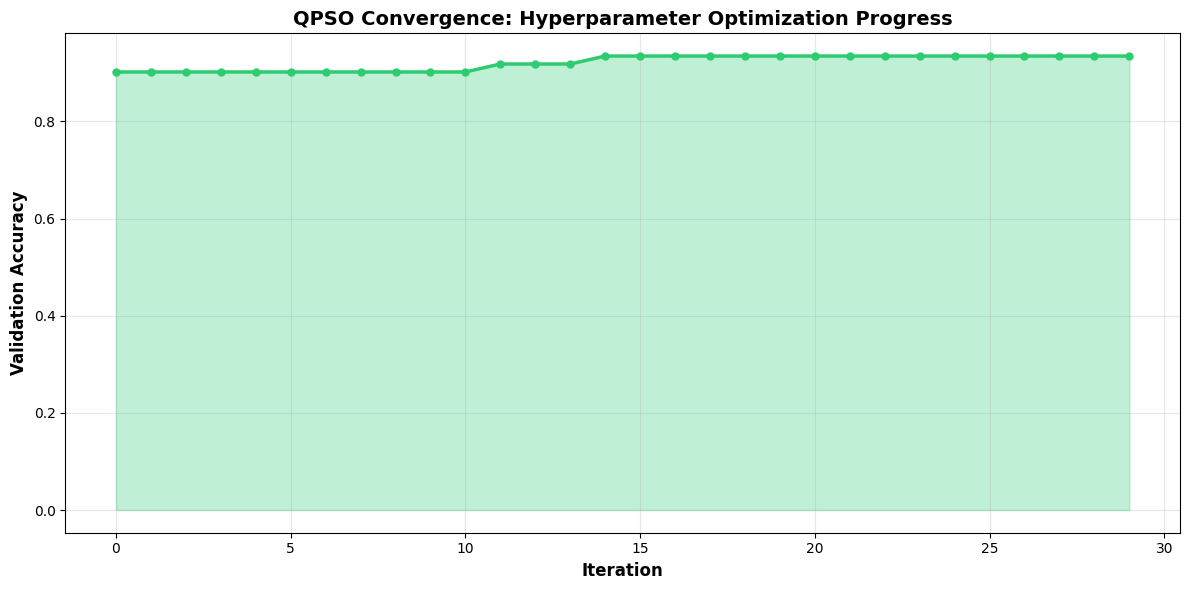


🎯 BEST HYPERPARAMETERS FOUND:
   Learning Rate:    0.008635
   Dropout Rate:     0.1979
   Number of Filters: 52
   Validation Accuracy: 0.9344


In [8]:
# ============================================================================
# PROPER QUANTUM-BEHAVED PARTICLE SWARM OPTIMIZATION (QPSO)
# ============================================================================

import numpy as np
import random
import matplotlib.pyplot as plt

class QPSO:
    """Quantum-behaved Particle Swarm Optimization for hyperparameter tuning"""

    def __init__(self, fitness_func, bounds, num_particles=20, max_iters=30):
        self.fitness_func = fitness_func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iters = max_iters
        self.dim = len(bounds)

        # QPSO parameters
        self.w = 0.9  # Inertia weight (will decay)
        self.alpha = 0.5  # Quantum uncertainty factor

        # Storage
        self.positions = None
        self.velocities = None
        self.pbest_positions = None
        self.pbest_values = None
        self.gbest_position = None
        self.gbest_value = -np.inf

        self.fitness_history = []

    def initialize(self):
        """Initialize particles randomly within bounds"""
        self.positions = np.array([
            [np.random.uniform(b[0], b[1]) for b in self.bounds]
            for _ in range(self.num_particles)
        ])

        self.velocities = np.array([
            [np.random.uniform(-0.1*(b[1]-b[0]), 0.1*(b[1]-b[0]))
             for b in self.bounds]
            for _ in range(self.num_particles)
        ])

        self.pbest_positions = self.positions.copy()
        self.pbest_values = np.full(self.num_particles, -np.inf)

    def evaluate(self):
        """Evaluate fitness for all particles"""
        fitness_values = np.zeros(self.num_particles)

        for i in range(self.num_particles):
            try:
                fitness_values[i] = self.fitness_func(list(self.positions[i]))
            except:
                fitness_values[i] = -np.inf

        return fitness_values

    def update_best(self, fitness_values):
        """Update personal and global best"""
        # Update personal best
        improved = fitness_values > self.pbest_values
        self.pbest_values[improved] = fitness_values[improved]
        self.pbest_positions[improved] = self.positions[improved]

        # Update global best
        max_idx = np.argmax(fitness_values)
        if fitness_values[max_idx] > self.gbest_value:
            self.gbest_value = fitness_values[max_idx]
            self.gbest_position = self.positions[max_idx].copy()
            print(f"    ✅ New best: {self.gbest_value:.4f}")

    def update_velocities(self, iteration):
        """QPSO velocity update with quantum mechanics"""
        # Calculate mean best position
        mbest = np.mean(self.pbest_positions, axis=0)

        # Decay inertia weight (start high, end low)
        self.w = 0.9 - (0.5 * iteration / self.max_iters)

        for i in range(self.num_particles):
            for d in range(self.dim):
                r1 = np.random.uniform(0, 1)
                r2 = np.random.uniform(0, 1)

                # Local attractor (combination of pbest and gbest)
                p_local = (r1 * self.pbest_positions[i, d] +
                          r2 * self.gbest_position[d])

                # Quantum uncertainty (core of QPSO)
                quantum_uncertainty = self.alpha * abs(mbest[d] - self.positions[i, d])

                # Quantum behavior: 50% move toward attractor, 50% explore randomly
                if np.random.uniform(0, 1) < 0.5:
                    # Standard PSO-like update (exploitation)
                    self.velocities[i, d] = (
                        self.w * self.velocities[i, d] +
                        1.49618 * np.random.uniform(0, 1) *
                        (p_local - self.positions[i, d])
                    )
                else:
                    # Quantum tunneling (exploration)
                    self.velocities[i, d] = np.random.uniform(
                        -quantum_uncertainty, quantum_uncertainty
                    )

    def update_positions(self):
        """Update particle positions and enforce bounds"""
        self.positions += self.velocities

        # Enforce bounds
        for d in range(self.dim):
            self.positions[:, d] = np.clip(
                self.positions[:, d],
                self.bounds[d][0],
                self.bounds[d][1]
            )

    def optimize(self):
        """Run QPSO optimization"""
        print("\n" + "="*70)
        print("🚀 QPSO HYPERPARAMETER OPTIMIZATION")
        print("="*70)
        print(f"Particles: {self.num_particles} | Iterations: {self.max_iters}")
        print("="*70 + "\n")

        self.initialize()

        for iteration in range(self.max_iters):
            print(f"📍 Iteration {iteration + 1}/{self.max_iters}")

            # Evaluate
            fitness_values = self.evaluate()

            # Update best
            self.update_best(fitness_values)
            self.fitness_history.append(self.gbest_value)

            # Update velocities and positions
            self.update_velocities(iteration)
            self.update_positions()

            # Print stats
            avg_fitness = np.mean(fitness_values[fitness_values > -np.inf])
            print(f"    Best: {self.gbest_value:.4f} | Avg: {avg_fitness:.4f} | w: {self.w:.3f}\n")

        print("="*70)
        print("✨ OPTIMIZATION COMPLETE")
        print("="*70)
        print(f"Best Fitness: {self.gbest_value:.4f}")
        print(f"Best Parameters: {self.gbest_position}")
        print("="*70 + "\n")

        return self.gbest_position, self.gbest_value

    def plot_convergence(self, save_path='qpso_convergence.png'):
        """Plot convergence curve"""
        fig, ax = plt.subplots(figsize=(12, 6))

        ax.plot(self.fitness_history, linewidth=2.5, color='#2ecc71',
                marker='o', markersize=5)
        ax.fill_between(range(len(self.fitness_history)),
                        self.fitness_history, alpha=0.3, color='#2ecc71')

        ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('QPSO Convergence: Hyperparameter Optimization Progress',
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved convergence plot: {save_path}")
        plt.show()


# ============================================================================
# RUN QPSO OPTIMIZATION
# ============================================================================

# Define hyperparameter bounds
param_bounds = [
    (1e-5, 1e-2),    # learning_rate
    (0.0, 0.5),      # dropout_rate
    (8, 64)          # n_filters
]

# Run QPSO
qpso = QPSO(
    fitness_func=evaluate_hyperparams,
    bounds=param_bounds,
    num_particles=20,      # More particles = better exploration
    max_iters=30           # More iterations = better convergence
)

best_params, best_acc = qpso.optimize()

# Plot convergence (Figure 5 for your paper)
qpso.plot_convergence(save_path='qpso_convergence.png')

# Extract best hyperparameters
best_lr, best_dropout, best_filters = best_params
best_filters = int(round(best_filters))

print(f"\n🎯 BEST HYPERPARAMETERS FOUND:")
print(f"   Learning Rate:    {best_lr:.6f}")
print(f"   Dropout Rate:     {best_dropout:.4f}")
print(f"   Number of Filters: {best_filters}")
print(f"   Validation Accuracy: {best_acc:.4f}")

In [9]:
# Train final model with best hyperparameters for more epochs
best_model = build_cnn_model(cat_cols, num_cols, cate_card, best_lr, best_dropout, best_filters)
best_model.fit(X_train_list, y_train, epochs=20, batch_size=16, verbose=1)
test_loss, test_acc = best_model.evaluate(X_test_list, y_test, verbose=0)
print(f"Final model accuracy on test set: {test_acc:.4f}")


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4824 - loss: 0.6984
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5726 - loss: 0.6522
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7514 - loss: 0.6055
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7785 - loss: 0.5297
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8249 - loss: 0.4322
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8223 - loss: 0.4105
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8615 - loss: 0.4148
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8475 - loss: 0.3704
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8951 - loss: 0.3102
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8908 - loss: 0.2868
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8920 - loss: 0.2818
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8964 - lo


📊 CONFUSION MATRIX & EVALUATION METRICS

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Confusion Matrix:
  True Negatives:  27
  False Positives: 6
  False Negatives: 2
  True Positives:  26

Performance Metrics:
  Sensitivity (Recall): 0.9286
  Specificity:          0.8182
  Precision:            0.8125
  F1-Score:             0.8667

Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.93      0.82      0.87        33
     Disease       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61


✅ Saved: confusion_matrix.png


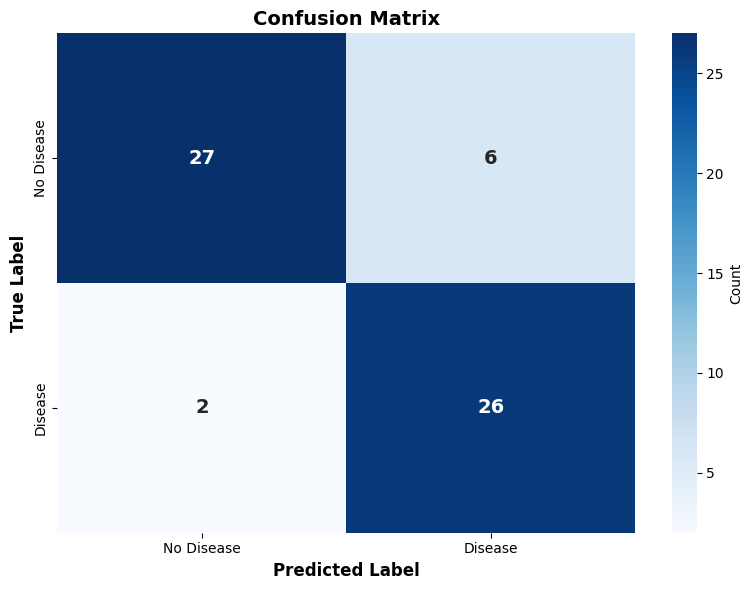

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

print("\n" + "="*70)
print("📊 CONFUSION MATRIX & EVALUATION METRICS")
print("="*70 + "\n")

# Get predictions
y_pred_proba = best_model.predict(X_test_list).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}\n")

# Calculate metrics
sensitivity = tp / (tp + fn)  # Recall for disease class
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print("Performance Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f}")
print(f"  Specificity:          {specificity:.4f}")
print(f"  Precision:            {precision:.4f}")
print(f"  F1-Score:             {f1:.4f}\n")

# Classification report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['No Disease', 'Disease']))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar_kws={'label': 'Count'},
            ax=ax,
            annot_kws={'size': 14, 'weight': 'bold'})

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: confusion_matrix.png")
plt.show()


📈 ROC-AUC CURVE

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
ROC-AUC Score: 0.9437

✅ Saved: roc_auc_curve.png



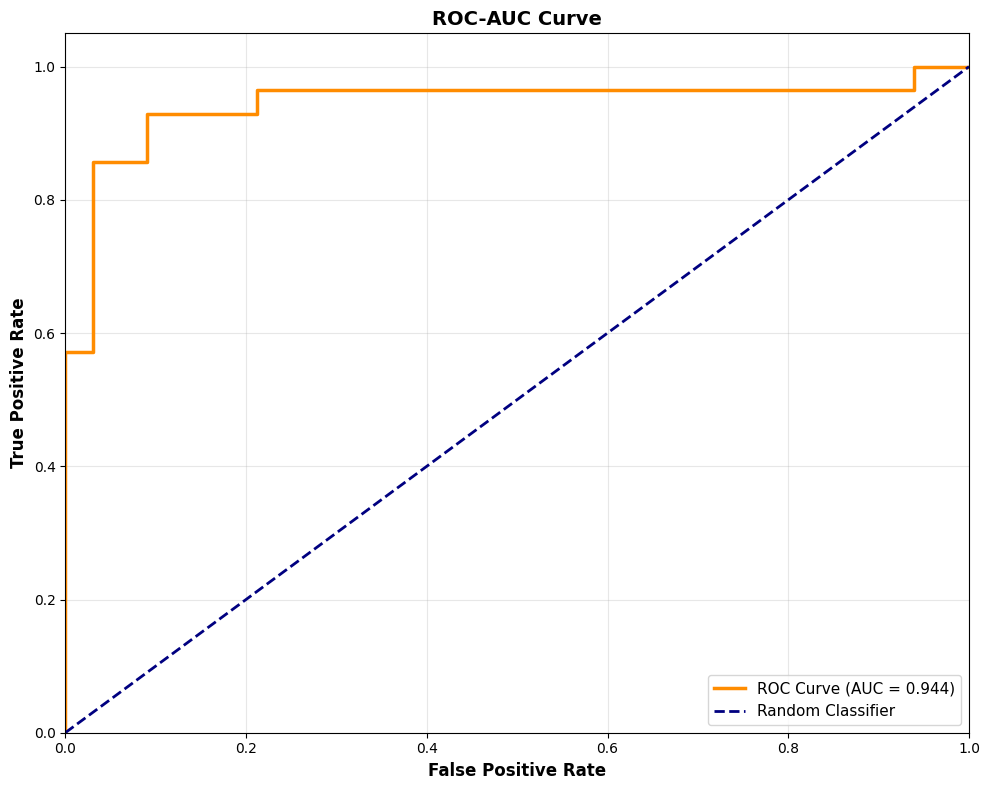

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

print("\n" + "="*70)
print("📈 ROC-AUC CURVE")
print("="*70 + "\n")

# Get predictions
y_pred_proba = best_model.predict(X_test_list).flatten()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"ROC-AUC Score: {roc_auc:.4f}\n")

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# ROC curve
ax.plot(fpr, tpr, color='darkorange', lw=2.5,
        label=f'ROC Curve (AUC = {roc_auc:.3f})')

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
        label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC-AUC Curve', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_auc_curve.png', dpi=300, bbox_inches='tight')
print("✅ Saved: roc_auc_curve.png\n")
plt.show()


📉 PRECISION-RECALL CURVE

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
✅ Saved: precision_recall_curve.png



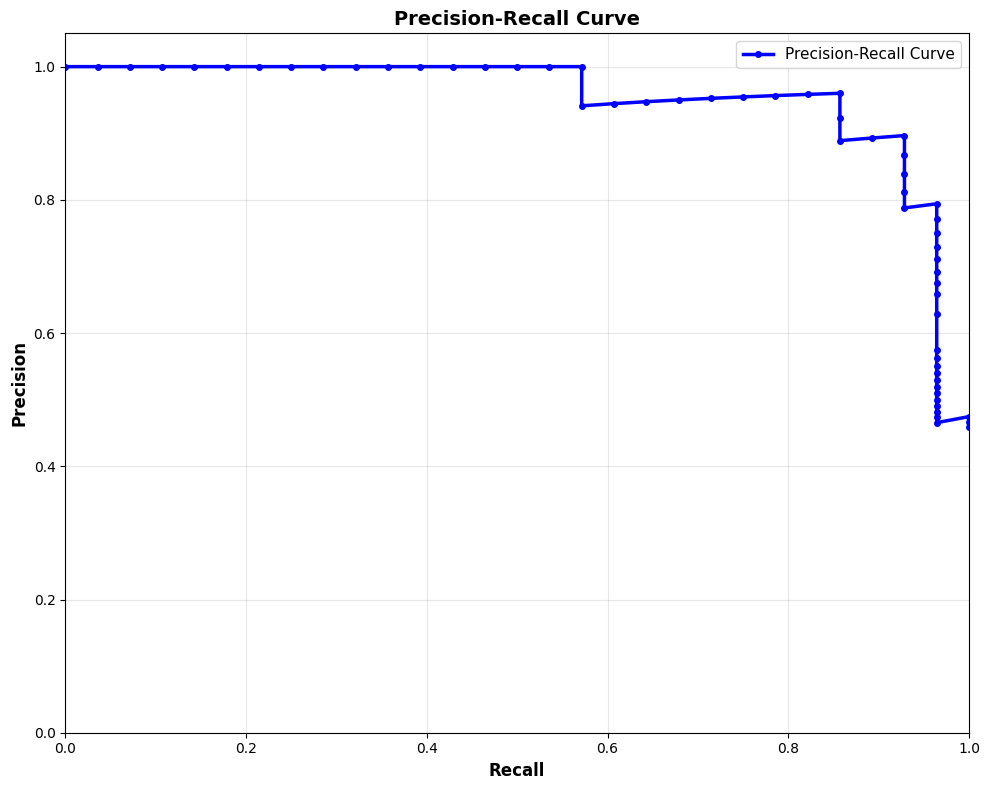

In [15]:
from sklearn.metrics import precision_recall_curve, f1_score

print("\n" + "="*70)
print("📉 PRECISION-RECALL CURVE")
print("="*70 + "\n")

# Get predictions
y_pred_proba = best_model.predict(X_test_list).flatten()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(recall, precision, color='blue', lw=2.5, marker='o', markersize=4,
        label='Precision-Recall Curve')

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend(loc="upper right", fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
print("✅ Saved: precision_recall_curve.png\n")
plt.show()

Background sample shape: (100, 13)
Test sample shape: (50, 13)

Initializing SHAP Explainer...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Computing SHAP values... please wait...


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
375/375 ━━━━━━

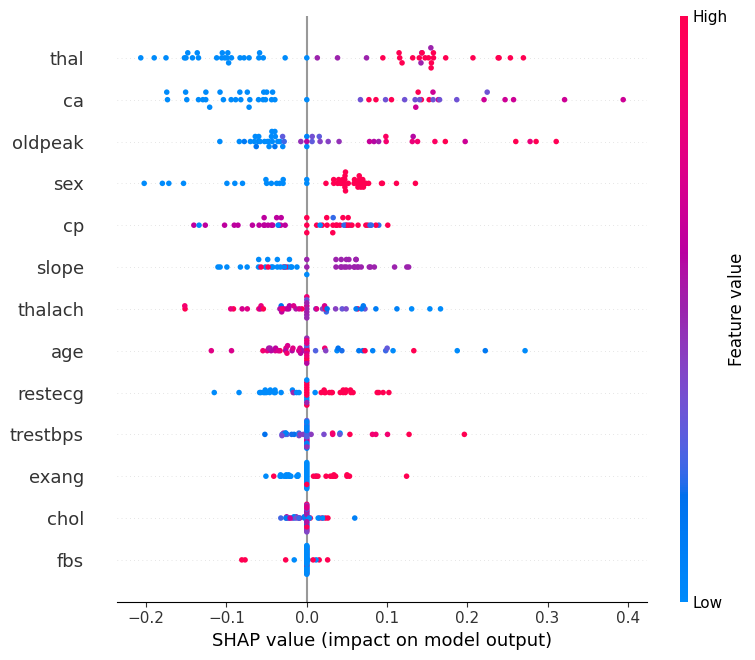

In [18]:
#################################################################
# STEP 1: Convert separate model inputs into single table format
#################################################################
def prepare_tabular_data(X_list):
    """
    Input: X_list = [cat1, cat2, ..., numeric_block]
    Returns combined matrix (N, total_features)
    """
    blocks = []

    # categorical inputs are arrays of shape (N,) → reshape to (N,1)
    for arr in X_list[:-1]:
        blocks.append(arr.reshape(-1, 1))

    # Numeric block already has shape (N, num_numeric_features)
    blocks.append(X_list[-1])

    # Horizontally concatenate
    return np.hstack(blocks)


# Prepare matrices
background_matrix = prepare_tabular_data(X_train_list)
test_matrix = prepare_tabular_data(X_test_list)

# Take a sample subset for faster computation
background_sample = background_matrix[:100]  # recommended
test_sample = test_matrix[:50]

print("Background sample shape:", background_sample.shape)
print("Test sample shape:", test_sample.shape)


#################################################################
# STEP 2: Model prediction wrapper for SHAP and LIME
#################################################################
def model_predict_wrapper(tabular_input):
    """
    Converts tabular input (N, total_features) into multi-input format
    and returns probabilities for both classes for LIME.

    Model expects: [cat_arrays..., numeric_matrix]
    """
    split_sizes = [1] * len(cat_cols) + [len(num_cols)]
    splits = np.split(tabular_input, np.cumsum(split_sizes)[:-1], axis=1)

    converted = []

    # Convert categorical columns back to (N,)
    for arr in splits[:-1]:
        converted.append(arr.flatten().astype(int))

    # Last one is numeric block
    converted.append(splits[-1].astype(float))

    # Return predictions - for LIME, need probabilities for both classes
    prob_disease = best_model.predict(converted).flatten()
    prob_no_disease = 1 - prob_disease
    return np.vstack([prob_no_disease, prob_disease]).transpose()


#################################################################
# STEP 3: Build SHAP KernelExplainer
#################################################################
print("\nInitializing SHAP Explainer...")
explainer = shap.KernelExplainer(
    model_predict_wrapper,
    background_sample
)


#################################################################
# STEP 4: Compute SHAP values
#################################################################
print("\nComputing SHAP values... please wait...")
shap_values = explainer.shap_values(test_sample, nsamples=120)


#################################################################
# STEP 5: Extract positive-class SHAP values correctly
#################################################################
if isinstance(shap_values, list):
    # shap_values is like [array_for_class0, array_for_class1]
    print("Case: SHAP returned LIST outputs.")
    shap_pos = shap_values[-1]

elif shap_values.ndim == 2:
    # Already shape (samples, features)
    print("Case: SHAP returned 2D array.")
    shap_pos = shap_values

elif shap_values.ndim == 3:
    # shape = (samples, features, classes)
    print("Case: SHAP returned 3D array.")
    shap_pos = shap_values[:, :, -1]

else:
    raise ValueError("Unsupported SHAP shape: " + str(shap_values.shape))

print("Final SHAP shape:", shap_pos.shape)


#################################################################
# STEP 6: Create feature name list
#################################################################
combined_feature_names = cat_cols + num_cols


#################################################################
# STEP 7: SHAP Visualization
#################################################################
shap.summary_plot(
    shap_pos,
    test_sample,
    feature_names=combined_feature_names
)

In [20]:
print("\n" + "="*70)
print("🔍 LIME EXPLANATIONS - Individual Predictions")
print("="*70 + "\n")

# ============================================================
# Prepare data for LIME
# ============================================================

X_test_tabular = np.hstack([
    X_test_list[i].reshape(-1, 1) if len(X_test_list[i].shape) == 1
    else X_test_list[i]
    for i in range(len(X_test_list))
])

feature_names = cat_cols + num_cols

explainer = LimeTabularExplainer(
    X_test_tabular,
    feature_names=feature_names,
    class_names=['No Disease', 'Disease'],
    mode='classification',
    random_state=42
)

# ============================================================
# Get predictions
# ============================================================

y_pred_proba = best_model.predict(X_test_list).flatten()

high_risk_idx = np.argmax(y_pred_proba)
low_risk_idx = np.argmin(y_pred_proba)
borderline_idx = np.argmin(np.abs(y_pred_proba - 0.5))

class_names = ['No Disease', 'Disease']

# ============================================================
# SAFE LIME PRINT FUNCTION (KEY FIX)
# ============================================================

def print_lime_explanation(exp, idx, title):
    pred_class = int(y_pred_proba[idx] >= 0.5)

    print("="*70)
    print(title)
    print("="*70)
    print(f"Disease Probability: {y_pred_proba[idx]:.4f}")
    print(f"Predicted Class: {class_names[pred_class]}\n")

    print("Top contributing features:")
    for feature, weight in exp.as_list(label=pred_class):
        print(f"  {feature:40} → Weight: {weight:+.4f}")

# ============================================================
# HIGH-RISK PATIENT
# ============================================================

exp_high = explainer.explain_instance(
    X_test_tabular[high_risk_idx],
    model_predict_wrapper,
    num_features=8,
    top_labels=2
)

print_lime_explanation(exp_high, high_risk_idx, "EXAMPLE 1: HIGH-RISK PATIENT")

# ============================================================
# LOW-RISK PATIENT (FIXED — NO KeyError)
# ============================================================

exp_low = explainer.explain_instance(
    X_test_tabular[low_risk_idx],
    model_predict_wrapper,
    num_features=8,
    top_labels=2
)

print_lime_explanation(exp_low, low_risk_idx, "EXAMPLE 2: LOW-RISK PATIENT")

# ============================================================
# BORDERLINE PATIENT
# ============================================================

exp_borderline = explainer.explain_instance(
    X_test_tabular[borderline_idx],
    model_predict_wrapper,
    num_features=8,
    top_labels=2
)

print_lime_explanation(
    exp_borderline,
    borderline_idx,
    "EXAMPLE 3: BORDERLINE PATIENT (≈50% probability)"
)

print("\n" + "="*70)
print("✅ LIME EXPLANATIONS COMPLETE")
print("="*70)
print("""
Interpretation:
• Positive weight → supports disease prediction
• Negative weight → supports no-disease prediction
""")



🔍 LIME EXPLANATIONS - Individual Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
EXAMPLE 1: HIGH-RISK PATIENT
Disease Probability: 0.9999
Predicted Class: Disease

Top contributing features:
  oldpeak > 1.00                           → Weight: +0.2969
  2.00 < cp <= 3.00                        → Weight: -0.1093
  trestbps > 0.47                          → Weight: +0.1057
  0.06 < age <= 0.62                       → Weight: -0.1018
  0.00 < ca <= 2.00                        → Weight: +0.0715
  1.00 < thal <= 3.00                      → Weight: +0.0550
  1.00 < restecg <= 2.00                   → Weight: +0.0478
  -0.77 < thalach <= 0.02                  → Weight: -0.0418
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
EXAMPLE 2: LOW-RISK PATIENT
Disease Probability: 0.0742
Predicted Class: No Disease

Top contributing features:
  thalach <= -0.77                         → Weight: -0.1704
  ca <= 0.00                               → Weight: +0.1671



📋 METRICS SUMMARY TABLE

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
             Metric  Value
           Accuracy 0.8689
Precision (Disease) 0.8125
   Recall (Disease) 0.9286
 F1-Score (Disease) 0.8667
Precision (Healthy) 0.9310
   Recall (Healthy) 0.8182
 F1-Score (Healthy) 0.8710
            ROC-AUC 0.9437


✅ Saved: evaluation_metrics.csv

✅ Saved: metrics_summary.png



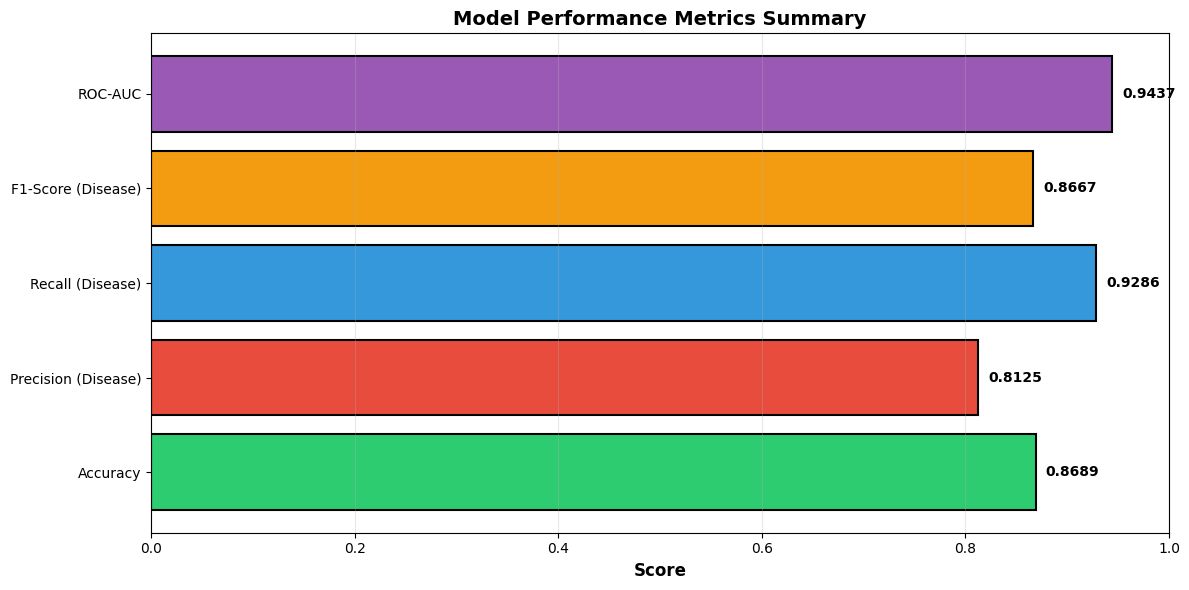

In [23]:
import pandas as pd

print("\n" + "="*70)
print("📋 METRICS SUMMARY TABLE")
print("="*70 + "\n")

# Get all predictions
y_pred_proba = best_model.predict(X_test_list).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Overall metrics
accuracy = accuracy_score(y_test, y_pred)
precision_overall = precision_score(y_test, y_pred, average='weighted')
recall_overall = recall_score(y_test, y_pred, average='weighted')
f1_overall = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Per-class metrics
precision_disease = precision_score(y_test, y_pred, pos_label=1)
recall_disease = recall_score(y_test, y_pred, pos_label=1)
f1_disease = f1_score(y_test, y_pred, pos_label=1)

precision_healthy = precision_score(y_test, y_pred, pos_label=0)
recall_healthy = recall_score(y_test, y_pred, pos_label=0)
f1_healthy = f1_score(y_test, y_pred, pos_label=0)

# Create table
metrics_data = {
    'Metric': [
        'Accuracy',
        'Precision (Disease)',
        'Recall (Disease)',
        'F1-Score (Disease)',
        'Precision (Healthy)',
        'Recall (Healthy)',
        'F1-Score (Healthy)',
        'ROC-AUC'
    ],
    'Value': [
        f'{accuracy:.4f}',
        f'{precision_disease:.4f}',
        f'{recall_disease:.4f}',
        f'{f1_disease:.4f}',
        f'{precision_healthy:.4f}',
        f'{recall_healthy:.4f}',
        f'{f1_healthy:.4f}',
        f'{roc_auc:.4f}'
    ]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False))
print("\n")

# Save to CSV
metrics_df.to_csv('evaluation_metrics.csv', index=False)
print("✅ Saved: evaluation_metrics.csv\n")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = [
    'Accuracy',
    'Precision (Disease)',
    'Recall (Disease)',
    'F1-Score (Disease)',
    'ROC-AUC'
]

values = [accuracy, precision_disease, recall_disease, f1_disease, roc_auc]
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']

bars = ax.barh(metrics_to_plot, values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value + 0.01, i, f'{value:.4f}', va='center', fontweight='bold')

ax.set_xlabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Metrics Summary', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1.0])
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_summary.png', dpi=300, bbox_inches='tight')
print("✅ Saved: metrics_summary.png\n")
plt.show()


⭐ FEATURE IMPORTANCE (Permutation Importance)

Computing permutation importance (safe single-thread mode)...

Top 10 Important Features:
 Feature  Importance      Std
    thal    0.095082 0.006557
      ca    0.081967 0.014663
 thalach    0.055738 0.024535
 oldpeak    0.042623 0.026636
      cp    0.039344 0.019672
     fbs    0.019672 0.006557
   slope    0.013115 0.012268
     sex    0.013115 0.024093
 restecg    0.013115 0.016062
trestbps    0.000000 0.010368

✅ Saved: feature_importance.csv
✅ Saved: feature_importance.png


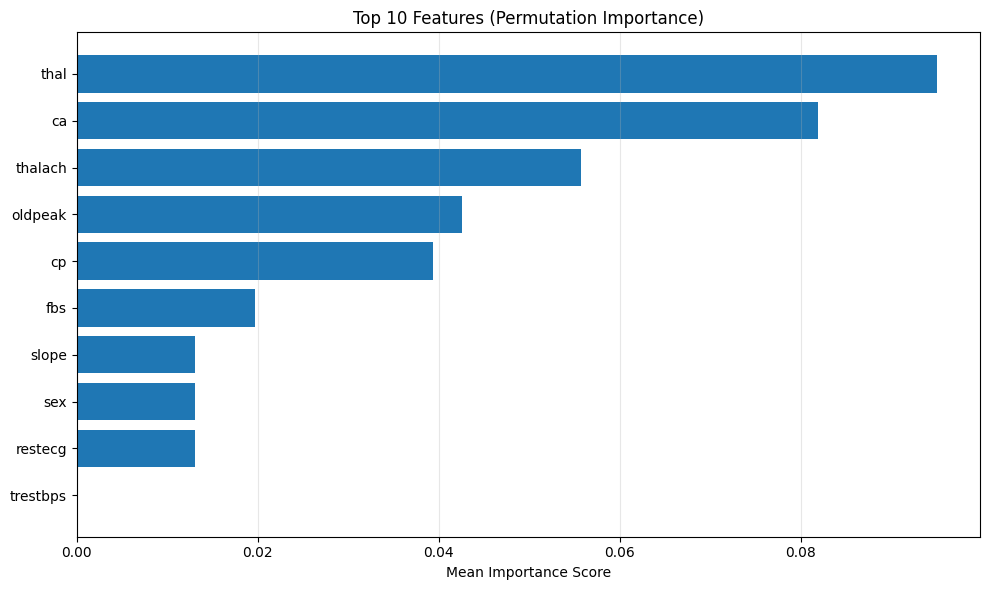

In [38]:
# ============================================================
# ⭐ FEATURE IMPORTANCE — PERMUTATION IMPORTANCE (STABLE FIX)
# ============================================================

print("\n" + "="*70)
print("⭐ FEATURE IMPORTANCE (Permutation Importance)")
print("="*70 + "\n")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

# ------------------------------------------------------------
# 1️⃣ SKLEARN-COMPATIBLE KERAS WRAPPER (THREAD-SAFE)
# ------------------------------------------------------------

class KerasPermutationWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, cat_cols, num_cols):
        self.model = model
        self.cat_cols = cat_cols
        self.num_cols = num_cols

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        X_list = []
        idx = 0

        # categorical features
        for _ in self.cat_cols:
            X_list.append(X[:, idx:idx+1].astype(np.int32))
            idx += 1

        # numerical features
        X_list.append(X[:, idx:].astype(np.float32))

        preds = self.model.predict(X_list, verbose=0)
        return (preds.flatten() > 0.5).astype(int)

    def predict_proba(self, X):
        X_list = []
        idx = 0

        for _ in self.cat_cols:
            X_list.append(X[:, idx:idx+1].astype(np.int32))
            idx += 1

        X_list.append(X[:, idx:].astype(np.float32))

        preds = self.model.predict(X_list, verbose=0).flatten()
        return np.column_stack([1 - preds, preds])


# ------------------------------------------------------------
# 2️⃣ PREPARE TABULAR DATA (NUMPY ONLY)
# ------------------------------------------------------------

X_test_tabular = np.hstack([
    X_test_list[i].reshape(-1, 1) if X_test_list[i].ndim == 1 else X_test_list[i]
    for i in range(len(X_test_list))
]).astype(np.float32)

y_test_binary = (y_test > 0).astype(int)

feature_names = cat_cols + num_cols

# ------------------------------------------------------------
# 3️⃣ WRAP TRAINED MODEL
# ------------------------------------------------------------

wrapped_model = KerasPermutationWrapper(
    model=best_model,
    cat_cols=cat_cols,
    num_cols=num_cols
)

# ------------------------------------------------------------
# 4️⃣ COMPUTE PERMUTATION IMPORTANCE (🔥 FIXED 🔥)
# ------------------------------------------------------------

print("Computing permutation importance (safe single-thread mode)...\n")

perm_importance = permutation_importance(
    estimator=wrapped_model,
    X=X_test_tabular[:100],        # subset for speed
    y=y_test_binary[:100],
    n_repeats=5,
    random_state=42,
    n_jobs=1,                      # 🚨 CRITICAL FIX
    scoring="accuracy"             # explicit scoring
)

# ------------------------------------------------------------
# 5️⃣ RESULTS TABLE
# ------------------------------------------------------------

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean,
    "Std": perm_importance.importances_std
}).sort_values(by="Importance", ascending=False)

print("Top 10 Important Features:")
print(importance_df.head(10).to_string(index=False))

# ------------------------------------------------------------
# 6️⃣ SAVE RESULTS
# ------------------------------------------------------------

importance_df.to_csv("feature_importance.csv", index=False)
print("\n✅ Saved: feature_importance.csv")

# ------------------------------------------------------------
# 7️⃣ VISUALIZATION
# ------------------------------------------------------------

top_features = importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.xlabel("Mean Importance Score")
plt.title("Top 10 Features (Permutation Importance)")
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()

plt.savefig("feature_importance.png", dpi=300)
print("✅ Saved: feature_importance.png")

plt.show()
